In [1]:
## imports
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, log_loss, matthews_corrcoef, cohen_kappa_score, roc_curve, auc, precision_recall_curve,accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score,train_test_split,cross_val_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from collections import Counter



In [2]:
# Define the function to load data
def load_team_data(base_url, seasons):
    team_df = pd.DataFrame()
    
    for season in seasons:
        url = base_url.format(season)
        try:
            # Read the data from the URL
            season_df = pd.read_html(url, attrs={"id": "matchlogs_for"})[0]
            
            # Add a column for the season
            season_df['Season'] = season
            
            # Concatenate the season's data to the main DataFrame
            team_df = pd.concat([team_df, season_df], ignore_index=True)
            
            print(f"Successfully loaded data for season {season}")
        except Exception as e:
            print(f"Failed to load data for season {season}: {e}")
        
        # Sleep for 5 seconds to avoid triggering a "too many requests" error
        time.sleep(5)
    
    return team_df

In [3]:
# Define the seasons
seasons = [f"{year}-{year+1}" for year in range(1996, 2024)]

# Base URL format for the Champions League stats
real_madrid_base_url = 'https://fbref.com/en/squads/53a2f082/{}/c8/Real-Madrid-Stats-Champions-League'
dortmund_base_url  = 'https://fbref.com/en/squads/add600ae/{}/c8/Dortmund-Stats-Champions-League'

# Initialize an empty DataFrame to hold all the data
realMadrid_df = pd.DataFrame()
dortmund_df = pd.DataFrame()

# Load data for Real Madrid
realMadrid_df = load_team_data(real_madrid_base_url, seasons)

# Load data for Dortmund
dortmund_df = load_team_data(dortmund_base_url, seasons)

# Display a sample of the loaded data
print(realMadrid_df.head())
print(dortmund_df.head())

# Save the combined DataFrames to CSV files for future use
realMadrid_df.to_csv('real_madrid_champions_league_1996_2024.csv', index=False)
dortmund_df.to_csv('dortmund_champions_league_1996_2024.csv', index=False)

Successfully loaded data for season 1996-1997
Successfully loaded data for season 1997-1998
Successfully loaded data for season 1998-1999
Successfully loaded data for season 1999-2000
Successfully loaded data for season 2000-2001
Successfully loaded data for season 2001-2002
Successfully loaded data for season 2002-2003
Successfully loaded data for season 2003-2004
Successfully loaded data for season 2004-2005
Successfully loaded data for season 2005-2006
Successfully loaded data for season 2006-2007
Successfully loaded data for season 2007-2008
Successfully loaded data for season 2008-2009
Successfully loaded data for season 2009-2010
Successfully loaded data for season 2010-2011
Successfully loaded data for season 2011-2012
Successfully loaded data for season 2012-2013
Successfully loaded data for season 2013-2014
Successfully loaded data for season 2014-2015
Successfully loaded data for season 2015-2016
Successfully loaded data for season 2016-2017
Successfully loaded data for seaso

In [4]:
def preprocess_team_data(df, output_filename):
    # Drop rows where 'Comp' is not NaN
    df = df[df['Comp'].isna()]
    
    # Drop rows where 'Result' is NaN
    df = df.dropna(subset=['Result'])
    
    # Drop the 'Notes' column
    if 'Notes' in df.columns:
        df = df.drop(columns=['Notes'])
    
    # Display DataFrame information
    print(df.info())
    
    # Save the preprocessed DataFrame to a CSV file
    df.to_csv(output_filename, index=False)
    
    return df

In [5]:
realMadrid_df = pd.read_csv('real_madrid_champions_league_1996_2024.csv')
realMadrid_df = preprocess_team_data(realMadrid_df, 'real_madrid_champions_league_1996_2024.csv')

dortmund_df = pd.read_csv('dortmund_champions_league_1996_2024.csv')
dortmund_df = preprocess_team_data(dortmund_df, 'dortmund_champions_league_1996_2024.csv')

<class 'pandas.core.frame.DataFrame'>
Index: 310 entries, 42 to 421
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          310 non-null    object 
 1   Time          116 non-null    object 
 2   Comp          0 non-null      object 
 3   Round         310 non-null    object 
 4   Day           310 non-null    object 
 5   Venue         310 non-null    object 
 6   Result        310 non-null    object 
 7   GF            310 non-null    object 
 8   GA            310 non-null    object 
 9   Opponent      310 non-null    object 
 10  Poss          116 non-null    float64
 11  Attendance    102 non-null    float64
 12  Captain       104 non-null    object 
 13  Formation     129 non-null    object 
 14  Referee       310 non-null    object 
 15  Match Report  310 non-null    object 
 16  Season        310 non-null    object 
 17  xG            78 non-null     float64
 18  xGA           78 non-null     floa

## **Processing the Data**

In [6]:
# Define the function to preprocess team data
def preprocess_team_goals(df):
    # Function to split goals into regular and penalty shootout scores
    def split_goals(goal):
        try:
            if '(' in goal:
                regular, penalty = goal.split('(')
                penalty = penalty.rstrip(')')
                return int(float(regular)), int(float(penalty))
            else:
                return int(float(goal)), 0
        except ValueError:
            return 0, 0  # Handle cases where conversion fails

    # Apply the function to split GF and GA
    df[['GF', 'GF_pen']] = df['GF'].astype(str).apply(split_goals).apply(pd.Series)
    df[['GA', 'GA_pen']] = df['GA'].astype(str).apply(split_goals).apply(pd.Series)

    # Rename the columns for clarity
    df.rename(columns={'GF': 'GF_reg', 'GA': 'GA_reg'}, inplace=True)

    # Display the updated DataFrame
    print(df[['GF_reg', 'GF_pen', 'GA_reg', 'GA_pen']].head())

    return df

In [7]:
realMadrid_df = preprocess_team_goals(realMadrid_df)
dortmund_df = preprocess_team_goals(dortmund_df)

    GF_reg  GF_pen  GA_reg  GA_pen
42       4       0       1       0
43       2       0       0       0
44       5       0       1       0
45       0       0       0       0
46       0       0       2       0
   GF_reg  GF_pen  GA_reg  GA_pen
0       2       0       1       0
1       3       0       0       0
2       1       0       0       0
3       1       0       2       0
4       2       0       2       0


In [8]:
# Create match outcome: 1 for win, 0 for lose/draw based on the final result including penalties
def determine_match_outcome(row):
    if row['GF_reg'] > row['GA_reg']:
        return 1
    elif row['GF_reg'] < row['GA_reg']:
        return 0
    else:  # If regular time is a draw, determine based on penalties
        if row['GF_pen'] > row['GA_pen']:
            return 1
        else:
            return 0

def preprocess_team_data(df,output_filename):

    # Create match outcome: 1 for win, 0 for lose/draw based on the final result including penalties
    df['match_outcome'] = df.apply(determine_match_outcome, axis=1)

    # Create goal difference using regular time goals
    df['goal_difference'] = df['GF_reg'] - df['GA_reg']

    # Create a binary feature for home advantage
    df['home_advantage'] = df['Venue'].apply(lambda x: 1 if x == 'Home' else 0)

    # Calculate rolling average of recent match outcomes (form)
    df = df.sort_values(by='Date')
    df['home_team_form'] = df['match_outcome'].rolling(window=5).mean().shift(1).fillna(0)

    # Calculate rolling average of goal difference
    df['goal_difference_rolling'] = df['goal_difference'].rolling(window=5).mean().shift(1).fillna(0)

    # Fill missing values for numeric columns with 0
    numeric_cols = ['Poss', 'Attendance', 'xG', 'xGA', 'GF_reg', 'GA_reg', 'GF_pen', 'GA_pen']
    df[numeric_cols] = df[numeric_cols].fillna(0)

    # For categorical columns
    categorical_cols = ['Time', 'Captain', 'Formation']
    df[categorical_cols] = df[categorical_cols].fillna('Unknown')

     # Save the preprocessed DataFrame to a CSV file
    df.to_csv(output_filename, index=False)

    return df      


In [9]:
realMadrid_df = preprocess_team_data(realMadrid_df, 'real_madrid_champions_league_1996_2024.csv')
dortmund_df = preprocess_team_data(dortmund_df, 'dortmund_champions_league_1996_2024.csv')

# Display a sample of the preprocessed data
print(realMadrid_df[['goal_difference', 'home_team_form', 'goal_difference_rolling', 'match_outcome']].head())
print(dortmund_df[['goal_difference', 'home_team_form', 'goal_difference_rolling', 'match_outcome']].head())

    goal_difference  home_team_form  goal_difference_rolling  match_outcome
42                3             0.0                      0.0              1
43                2             0.0                      0.0              1
44                4             0.0                      0.0              1
45                0             0.0                      0.0              0
46               -2             0.0                      0.0              0
   goal_difference  home_team_form  goal_difference_rolling  match_outcome
0                1             0.0                      0.0              1
1                3             0.0                      0.0              1
2                1             0.0                      0.0              1
3               -1             0.0                      0.0              0
4                0             0.0                      0.0              0


In [10]:
# Add a column to identify the team
realMadrid_df['team'] = 'Real Madrid'
dortmund_df['team'] = 'Dortmund'

# Combine both datasets
combined_df = pd.concat([realMadrid_df, dortmund_df], ignore_index=True)

# Display a sample of the combined data
print(combined_df.head())

         Date     Time Comp        Round  Day Venue Result  GF_reg  GA_reg  \
0  1997-09-17  Unknown  NaN  Group stage  Wed  Home      W       4       1   
1  1997-10-01  Unknown  NaN  Group stage  Wed  Away      W       2       0   
2  1997-10-22  Unknown  NaN  Group stage  Wed  Home      W       5       1   
3  1997-11-05  Unknown  NaN  Group stage  Wed  Away      D       0       0   
4  1997-11-27  Unknown  NaN  Group stage  Thu  Away      L       0       2   

        Opponent  ...   xG  xGA GF_pen GA_pen match_outcome goal_difference  \
0   no Rosenborg  ...  0.0  0.0      0      0             1               3   
1       pt Porto  ...  0.0  0.0      0      0             1               2   
2  gr Olympiacos  ...  0.0  0.0      0      0             1               4   
3  gr Olympiacos  ...  0.0  0.0      0      0             0               0   
4   no Rosenborg  ...  0.0  0.0      0      0             0              -2   

  home_advantage  home_team_form  goal_difference_rollin

In [11]:
# Define features and target
features = ['home_team_form', 'goal_difference_rolling', 'home_advantage', 'Poss']
target = 'match_outcome'

X = combined_df[features]
y = combined_df[target]

# Display the features and target to verify
print(X.head())
print(y.head())


   home_team_form  goal_difference_rolling  home_advantage  Poss
0             0.0                      0.0               1   0.0
1             0.0                      0.0               0   0.0
2             0.0                      0.0               1   0.0
3             0.0                      0.0               0   0.0
4             0.0                      0.0               0   0.0
0    1
1    1
2    1
3    0
4    0
Name: match_outcome, dtype: int64


In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shape of the datasets
print(f'Training set: {X_train.shape}, Testing set: {X_test.shape}')


Training set: (372, 4), Testing set: (94, 4)


In [13]:
# Train the Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(f'Model Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

final_match_data = {
    'home_team_form': [realMadrid_df['home_team_form'].iloc[-1], dortmund_df['home_team_form'].iloc[-1]],  # Current form of both teams
    'goal_difference_rolling': [realMadrid_df['goal_difference_rolling'].iloc[-1], dortmund_df['goal_difference_rolling'].iloc[-1]],  # Current rolling goal difference of both teams
    'home_advantage': [1, 0],  # Assume Real Madrid has home advantage (or 0 for neutral venue)
    'Poss': [realMadrid_df['Poss'].iloc[-1], dortmund_df['Poss'].iloc[-1]]  # Current possession percentage
}

final_match_df = pd.DataFrame(final_match_data)

# Predict the outcome of the final match
prediction = model.predict(final_match_df)
prediction_proba = model.predict_proba(final_match_df)

print(f'Predicted Outcome: {"Real Madrid Wins" if prediction[0] == 1 else "Dortmund Wins/Draws"}')
print(f'Prediction Probability: {prediction_proba}')


Model Accuracy: 0.5851063829787234
              precision    recall  f1-score   support

           0       0.61      0.32      0.42        44
           1       0.58      0.82      0.68        50

    accuracy                           0.59        94
   macro avg       0.59      0.57      0.55        94
weighted avg       0.59      0.59      0.56        94

Predicted Outcome: Real Madrid Wins
Prediction Probability: [[0.31995952 0.68004048]
 [0.51002838 0.48997162]]


In [14]:
# Adding additional features to the combined dataframe
combined_df['recent_goals_scored'] = combined_df['GF_reg'].rolling(window=3).mean().shift(1).fillna(0)
combined_df['recent_goals_conceded'] = combined_df['GA_reg'].rolling(window=3).mean().shift(1).fillna(0)

# Ensure no NaN values
combined_df.fillna(0, inplace=True)

# Define new feature set
features = ['home_team_form', 'goal_difference_rolling', 'home_advantage', 'Poss', 'recent_goals_scored', 'recent_goals_conceded']
target = 'match_outcome'

X = combined_df[features]
y = combined_df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(rf_model, X, y, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Average Cross-Validation Score: {np.mean(cv_scores)}')

# Evaluate the model on the test set
y_pred = rf_model.predict(X_test)
print(f'Model Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

# Predict the outcome of the final match
final_match_data = {
    'home_team_form': [realMadrid_df['home_team_form'].iloc[-1], dortmund_df['home_team_form'].iloc[-1]],
    'goal_difference_rolling': [realMadrid_df['goal_difference_rolling'].iloc[-1], dortmund_df['goal_difference_rolling'].iloc[-1]],
    'home_advantage': [1, 0],
    'Poss': [realMadrid_df['Poss'].iloc[-1], dortmund_df['Poss'].iloc[-1]],
    'recent_goals_scored': [realMadrid_df['GF_reg'].rolling(window=3).mean().iloc[-1], dortmund_df['GF_reg'].rolling(window=3).mean().iloc[-1]],
    'recent_goals_conceded': [realMadrid_df['GA_reg'].rolling(window=3).mean().iloc[-1], dortmund_df['GA_reg'].rolling(window=3).mean().iloc[-1]]
}

final_match_df = pd.DataFrame(final_match_data)

# Predict the outcome of the final match
prediction = rf_model.predict(final_match_df)
prediction_proba = rf_model.predict_proba(final_match_df)

print(f'Predicted Outcome: {"Real Madrid Wins" if prediction[0] == 1 else "Dortmund Wins/Draws"}')
print(f'Prediction Probability: {prediction_proba}')


Cross-Validation Scores: [0.5212766  0.52688172 0.46236559 0.53763441 0.53763441]
Average Cross-Validation Score: 0.5171585449553878
Model Accuracy: 0.5212765957446809
              precision    recall  f1-score   support

           0       0.48      0.34      0.40        44
           1       0.54      0.68      0.60        50

    accuracy                           0.52        94
   macro avg       0.51      0.51      0.50        94
weighted avg       0.51      0.52      0.51        94

Predicted Outcome: Real Madrid Wins
Prediction Probability: [[0.27166667 0.72833333]
 [0.3885     0.6115    ]]


In [20]:
# Combine both datasets
match_data_df = pd.concat([realMadrid_df, dortmund_df], ignore_index=True)

# Additional feature engineering
match_data_df['recent_goals_scored'] = match_data_df['GF_reg'].rolling(window=3).mean().shift(1).fillna(0)
match_data_df['recent_goals_conceded'] = match_data_df['GA_reg'].rolling(window=3).mean().shift(1).fillna(0)
match_data_df['cumulative_goal_difference'] = match_data_df['goal_difference'].cumsum().shift(1).fillna(0)

# Add match importance weights
round_weights = {
    'Group stage': 1,
    'Quarter-finals': 2,
    'Semi-finals': 3,
    'Final': 4
}
match_data_df['round_weight'] = match_data_df['Round'].map(round_weights).fillna(0)

# Add head-to-head feature
real_vs_dortmund = (match_data_df['team'] == 'Real Madrid') & (match_data_df['Opponent'].str.contains('Dortmund', case=False))
dortmund_vs_real = (match_data_df['team'] == 'Dortmund') & (match_data_df['Opponent'].str.contains('Real Madrid', case=False))

real_wins = match_data_df[real_vs_dortmund & (match_data_df['Result'] == 'W')].shape[0]
dortmund_wins = match_data_df[dortmund_vs_real & (match_data_df['Result'] == 'W')].shape[0]

match_data_df['head_to_head_weight'] = match_data_df.apply(
    lambda row: real_wins if (row['team'] == 'Real Madrid' and 'Dortmund' in row['Opponent']) else (
        dortmund_wins if (row['team'] == 'Dortmund' and 'Real Madrid' in row['Opponent']) else 0), axis=1
)

# Ensure no NaN values
match_data_df.fillna(0, inplace=True)

# Define new feature set
features = [
    'home_team_form', 'goal_difference_rolling', 'home_advantage',
    'recent_goals_scored', 'recent_goals_conceded', 'cumulative_goal_difference',
    'round_weight', 'head_to_head_weight'
]
target = 'match_outcome'

X = match_data_df[features]
y = match_data_df[target]

# Check the initial class distribution
print("Initial class distribution:", Counter(y))

# Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check the balanced class distribution
print("Balanced class distribution:", Counter(y_resampled))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Define the XGBoost model with regularization parameters
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, reg_alpha=0.1, reg_lambda=0.1)

# Hyperparameter tuning for XGBoost with increased cross-validation folds
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],  # L1 regularization
    'reg_lambda': [0, 0.1, 0.5]  # L2 regularization
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=10, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters from Grid Search
best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')

# Train the model with the best parameters
best_xgb_model = xgb.XGBClassifier(**best_params, objective='binary:logistic', random_state=42)
best_xgb_model.fit(X_train, y_train)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(best_xgb_model, X_resampled, y_resampled, cv=10)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Average Cross-Validation Score: {np.mean(cv_scores)}')

# Evaluate the model on the test set
y_pred = best_xgb_model.predict(X_test)
print(f'Model Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

final_match_data = {
    'home_team_form': [realMadrid_df['home_team_form'].iloc[-1], dortmund_df['home_team_form'].iloc[-1]],
    'goal_difference_rolling': [realMadrid_df['goal_difference_rolling'].iloc[-1], dortmund_df['goal_difference_rolling'].iloc[-1]],
    'home_advantage': [1, 0],
    'recent_goals_scored': [realMadrid_df['GF_reg'].rolling(window=3).mean().iloc[-1], dortmund_df['GF_reg'].rolling(window=3).mean().iloc[-1]],
    'recent_goals_conceded': [realMadrid_df['GA_reg'].rolling(window=3).mean().iloc[-1], dortmund_df['GA_reg'].rolling(window=3).mean().iloc[-1]],
    'cumulative_goal_difference': [realMadrid_df['goal_difference'].cumsum().iloc[-1], dortmund_df['goal_difference'].cumsum().iloc[-1]],
    'round_weight': [round_weights.get('Final', 0), round_weights.get('Final', 0)],
    'head_to_head_weight': [real_wins, dortmund_wins]
}

final_match_df = pd.DataFrame(final_match_data)

# Predict the outcome of the final match
prediction = best_xgb_model.predict(final_match_df)
prediction_proba = best_xgb_model.predict_proba(final_match_df)

print(f'Predicted Outcome: {"Real Madrid Wins" if prediction[0] == 1 else "Dortmund Wins/Draws"}')
print(f'Prediction Probability: {prediction_proba}')


Initial class distribution: Counter({1: 268, 0: 198})
Balanced class distribution: Counter({1: 268, 0: 268})
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 50, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 1.0}
Cross-Validation Scores: [0.72222222 0.59259259 0.31481481 0.24074074 0.2962963  0.27777778
 0.41509434 0.54716981 0.50943396 0.41509434]
Average Cross-Validation Score: 0.4331236897274633
Model Accuracy: 0.7592592592592593
              precision    recall  f1-score   support

           0       0.80      0.74      0.77        58
           1       0.72      0.78      0.75        50

    accuracy                           0.76       108
   macro avg       0.76      0.76      0.76       108
weighted avg       0.76      0.76      0.76       108

Predicted Outcome: Real Madrid Wins
Prediction Probability: [[0.43661982 0.5633802 ]
 [0.57344866 0.42655134]]


Precision: 0.7222222222222222
Recall: 0.78
F1-Score: 0.7500000000000001
Confusion Matrix:
[[43 15]
 [11 39]]
Log Loss: 0.6382122524557452
Matthews Correlation Coefficient: 0.5199469468957452
Cohen’s Kappa: 0.5185185185185186


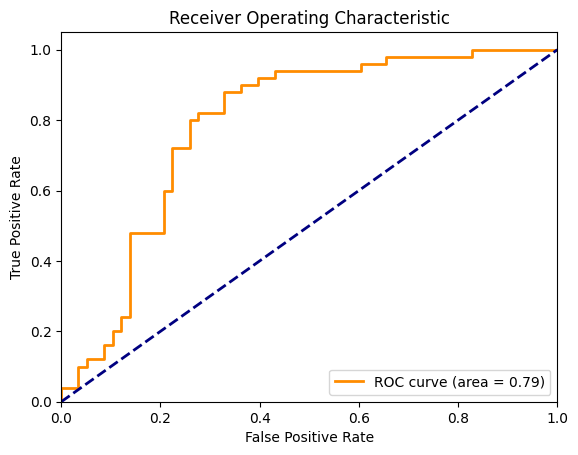

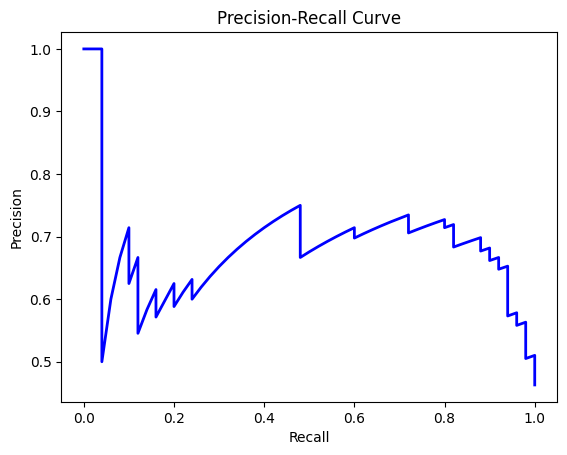

In [19]:
# Predict on the test set
y_pred = best_xgb_model.predict(X_test)
y_pred_proba = best_xgb_model.predict_proba(X_test)[:, 1]

# Calculate Precision, Recall, and F1-Score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{conf_matrix}')

# Log Loss
log_loss_value = log_loss(y_test, y_pred_proba)
print(f'Log Loss: {log_loss_value}')

# Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_test, y_pred)
print(f'Matthews Correlation Coefficient: {mcc}')

# Cohen’s Kappa
kappa = cohen_kappa_score(y_test, y_pred)
print(f'Cohen’s Kappa: {kappa}')

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()
